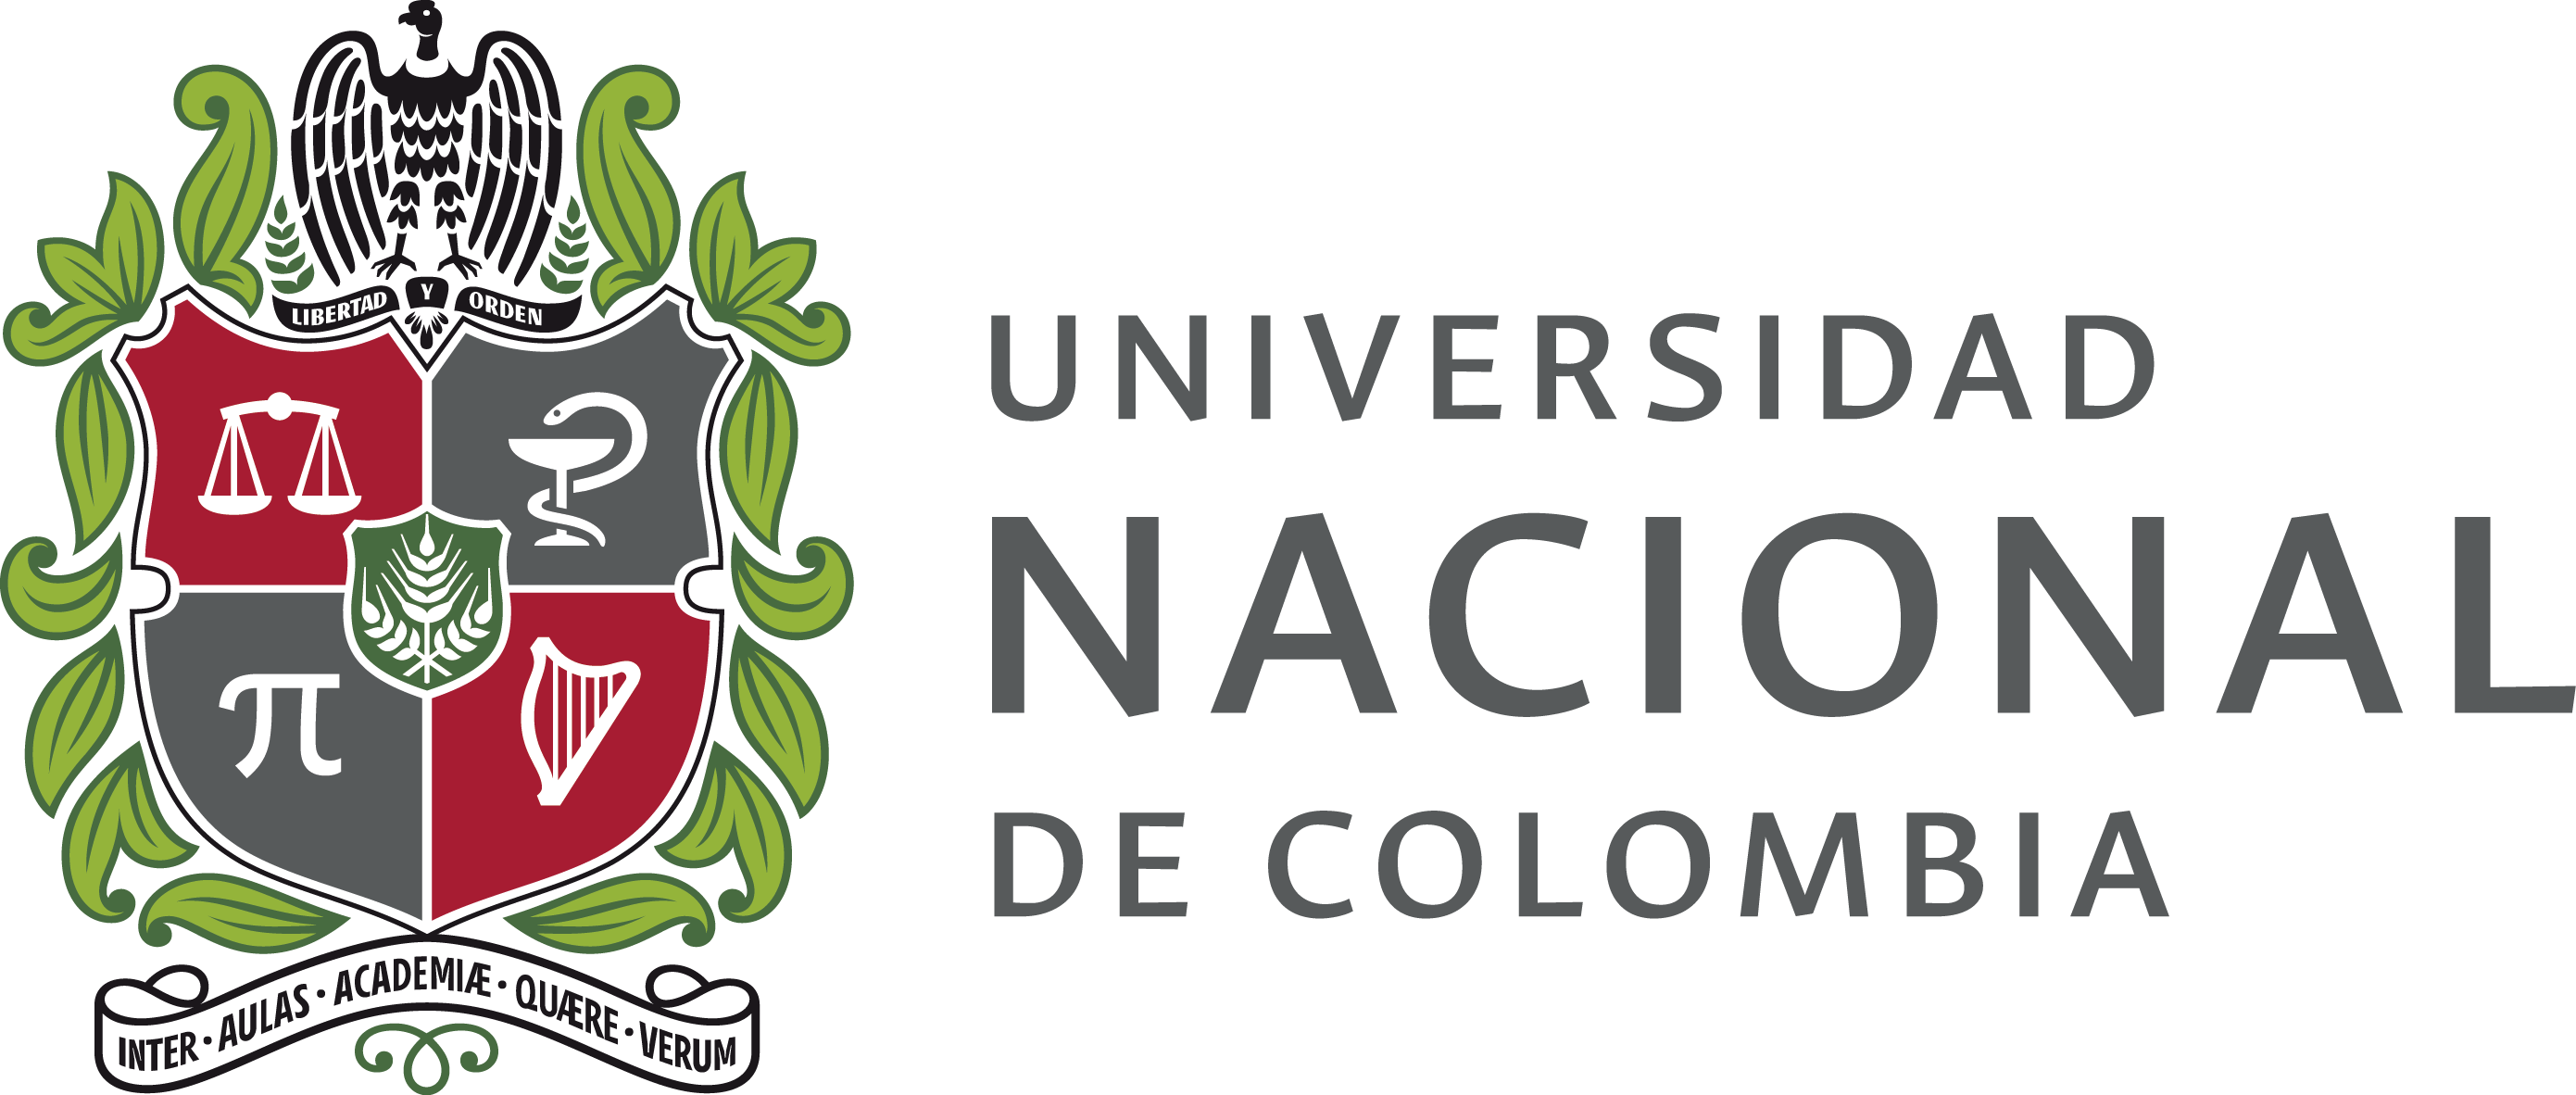
### **Universidad Nacional de Colombia sede Manizales**
#### Facultad de ingeniería y arquitecura
#### Departamento de ingeniería eléctrica, electrónica y computación
#### *Procesamiento digital de imágenes*

#### Profesor: Lucas Iturriago

#### Estudiantes: Felipe Idarraga - Julian Gutierrez

## Instalación de roboflow

In [1]:
%%capture
!pip install roboflow

## Importación de librerias

In [2]:
import os
import re
import glob
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from roboflow import Roboflow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.io
from torchvision.ops import nms, box_iou
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as TF

## Importación Base de datos para nuestro Proyecto final

Esta celda se conecta a Roboflow, abre el proyecto License Plate Recognition, selecciona la versión 3 y descarga el dataset en formato YOLOv8 para usarlo en el entrenamiento.

In [3]:
rf = Roboflow(api_key="EU6CNFEXAJALgtrg7i6E")
project = rf.workspace("pdi-v2wy7").project("license-plate-recognition-rxg4e-mpg7r")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-3 in yolov8:: 100%|██████████| 20262/20262 [00:01<00:00, 11106.23it/s]


## Semilla
Esta celda fija una semilla aleatoria (42) y la aplica a PyTorch y CUDA, garantizando que los experimentos sean reproducibles y generen siempre los mismos resultados.

In [4]:
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## Definición del Dataset y DataLoader para detección de placas

Este código crea un Dataset personalizado que carga imágenes y etiquetas de detección, aplica el preprocesamiento y las aumentaciones necesarias, y define un DataLoader para iterar eficientemente sobre los datos en entrenamiento, validación o prueba.

In [5]:
class Detection_Dataset(Dataset):
    def __init__(self, data_dir, image_size, num_classes, partition, augment=True):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.image_size = image_size
        self.num_classes = num_classes
        self.partition = partition
        self.augment = augment and (partition.lower() == 'train')
        
        images_path = self.data_dir / self.partition / 'images'
        labels_path = self.data_dir / self.partition / 'labels'
        
        supported_formats = ['*.png', '*.jpg', '*.jpeg']
        image_files = []
        
        for format_pattern in supported_formats:
            files = glob.glob(str(images_path / format_pattern))
            image_files.extend(files)
        
        self.samples = []
        self.labels = []
        
        for img_path in image_files:
            img_path = Path(img_path)
            label_path = labels_path / f"{img_path.stem}.txt"
            if label_path.exists():
                self.samples.append(str(img_path))
                self.labels.append(str(label_path))
        
        sorted_pairs = sorted(zip(self.samples, self.labels), key=lambda x: self._alphanumeric_key(x[0]))
        self.samples = [x[0] for x in sorted_pairs]
        self.labels = [x[1] for x in sorted_pairs]
        
        self.num_samples = len(self.samples)
        print(f"Found {self.num_samples} image-label pairs in {partition}")

    @staticmethod
    def _alphanumeric_key(s):
        return [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', s)]

    def __len__(self):
        return self.num_samples

    def process_image(self, file_path):
        img = torchvision.io.read_image(str(file_path), mode=ImageReadMode.RGB)
        original_size = img.shape[1:]
        img = TF.resize(img, list(self.image_size), interpolation=TF.InterpolationMode.BILINEAR)
        if img.float().max() > 1.0:
            img = img.float() / 255.0
        else:
            img = img.float()
        return img, original_size

    def process_labels(self, file_path):
        boxes = []
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    class_id = int(parts[0])
                    center_x = float(parts[1])
                    center_y = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    boxes.append([class_id, center_x, center_y, width, height])
        
        if len(boxes) == 0:
            return torch.zeros((0, 5), dtype=torch.float32)
        
        return torch.tensor(boxes, dtype=torch.float32)

    def apply_augmentation(self, image, boxes):
        if len(boxes) == 0:
            return image, boxes
        
        if random.random() > 0.5:
            image = TF.hflip(image)
            boxes[:, 1] = 1.0 - boxes[:, 1]
        
        if random.random() > 0.5:
            image = TF.vflip(image)
            boxes[:, 2] = 1.0 - boxes[:, 2]
        
        if random.random() > 0.5:
            image = TF.adjust_brightness(image, random.uniform(0.8, 1.2))
        if random.random() > 0.5:
            image = TF.adjust_contrast(image, random.uniform(0.8, 1.2))
        if random.random() > 0.5:
            image = TF.adjust_saturation(image, random.uniform(0.8, 1.2))
        if random.random() > 0.7:
            noise = torch.randn_like(image) * 0.02
            image = torch.clamp(image + noise, 0, 1)
        
        return image, boxes

    def __getitem__(self, idx):
        image, original_size = self.process_image(self.samples[idx])
        boxes = self.process_labels(self.labels[idx])
        
        if self.augment:
            image, boxes = self.apply_augmentation(image, boxes)
        
        return image, boxes


def collate_fn(batch):
    images = []
    targets = []
    
    for image, boxes in batch:
        images.append(image)
        targets.append(boxes)
    
    images = torch.stack(images, 0)
    return images, targets


def Detection_DataLoader(data_dir, batch_size, image_size, num_classes, partition, augment=True, 
                         num_workers=4, prefetch_factor=2, pin_memory=True):
    dataset = Detection_Dataset(
        data_dir=data_dir,
        image_size=image_size,
        num_classes=num_classes,
        partition=partition,
        augment=augment
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(partition.lower() == 'train'),
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor if num_workers > 0 else None,
        persistent_workers=(num_workers > 0),
        collate_fn=collate_fn
    )

## Creación de DataLoaders para train, valid y test

Esta celda construye los DataLoader de entrenamiento, validación y prueba a partir del dataset de placas, usando el mismo tamaño de imagen y batch, aplicando aumentación solo al conjunto de train.

In [6]:
train_data = Detection_DataLoader(
    data_dir="/kaggle/working/License-Plate-Recognition-3",
    batch_size=32,
    image_size=(416, 416),
    partition="train",
    augment=True,
    num_classes=1
)

valid_data = Detection_DataLoader(
    data_dir="/kaggle/working/License-Plate-Recognition-3",
    batch_size=32,
    image_size=(416, 416),
    partition="valid",
    augment=False,
    num_classes=1
)

test_data = Detection_DataLoader(
    data_dir="/kaggle/working/License-Plate-Recognition-3",
    batch_size=32,
    image_size=(416, 416),
    partition="test",
    augment=False,
    num_classes=1
)

Found 7057 image-label pairs in train
Found 2048 image-label pairs in valid
Found 1020 image-label pairs in test


## Obtención de un batch de entrenamiento

Esta celda extrae el primer batch del DataLoader de entrenamiento, permitiendo visualizar o verificar que las imágenes y etiquetas se estén cargando correctamente.

In [7]:
batch = next(iter(train_data))

## Visualización de una imagen con sus bounding boxes

Esta celda toma una imagen del batch de entrenamiento, la muestra con matplotlib y dibuja sobre ella los bounding boxes y las clases asociadas, para verificar gráficamente que las anotaciones del dataset sean correctas.

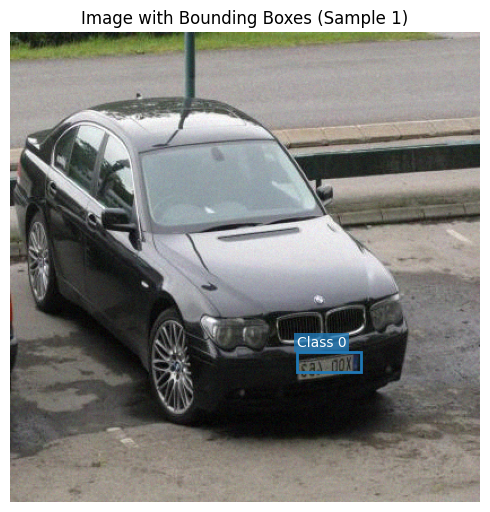

In [8]:
sample = 1
images, targets = batch

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

img = images[sample].cpu().permute(1, 2, 0).numpy()
ax.imshow(img)

boxes = targets[sample].cpu().numpy()
h, w = images[sample].shape[1], images[sample].shape[2]

colors = plt.cm.tab10(range(10))

for box in boxes:
    class_id = int(box[0])
    center_x = box[1] * w
    center_y = box[2] * h
    width = box[3] * w
    height = box[4] * h
    
    x1 = center_x - width / 2
    y1 = center_y - height / 2
    
    rect = patches.Rectangle(
        (x1, y1), width, height,
        linewidth=2,
        edgecolor=colors[class_id % 10],
        facecolor='none'
    )
    ax.add_patch(rect)
    
    ax.text(
        x1, y1 - 5,
        f'Class {class_id}',
        color='white',
        fontsize=10,
        bbox=dict(facecolor=colors[class_id % 10], alpha=0.8, edgecolor='none', pad=2)
    )

ax.set_title(f'Image with Bounding Boxes (Sample {sample})')
ax.axis('off')

plt.tight_layout()
plt.show()

## Definición del modelo de detección de placas (YOLOv3 Mini mejorado)

Esta celda implementa un detector de placas basado en una versión ligera de YOLOv3, con bloques residuales, un módulo SPP para contexto multi-escala y una cabeza de detección que usa anchors; además incluye una función decode para convertir las predicciones de la red en cajas en píxeles, scores y clases.

In [9]:
# ============================================================================
#   MODELO DE DETECCIÓN DE PLACAS V2 - YOLOv3 MINI MEJORADO
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 1, bias=False),
            nn.BatchNorm2d(channels // 2),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(channels // 2, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x):
        return x + self.conv(x)


class SPPBlock(nn.Module):
    """
    Spatial Pyramid Pooling muy simple:
    concatena maxpools de distintos tamaños para dar contexto multi-escala.
    """
    def __init__(self, channels):
        super().__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=9, stride=1, padding=4)
        self.pool3 = nn.MaxPool2d(kernel_size=13, stride=1, padding=6)

    def forward(self, x):
        p1 = self.pool1(x)
        p2 = self.pool2(x)
        p3 = self.pool3(x)
        # concatena a lo largo de canales
        return torch.cat([x, p1, p2, p3], dim=1)  # [B, 4*C, H, W]


class ImprovedPlateDetector(nn.Module):
    def __init__(self, num_classes=1, image_size=(416, 416), num_anchors=3, anchors=None):
        super().__init__()

        self.num_classes = num_classes
        self.image_size = image_size
        self.num_anchors = num_anchors

        # Si no se especifican anchors, usamos unos aproximados (los tuyos de k-means los pasas al instanciar)
        self.anchors = anchors or [
            [40, 14],
            [80, 28],
            [120, 40]
        ]
        self.anchors = torch.tensor(self.anchors).float()

        # ---------------------------------------------------------------------
        #   BACKBONE ESTILO YOLO (UN POCO MÁS PROFUNDO)
        # ---------------------------------------------------------------------
        def conv_block(in_c, out_c, kernel=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel, stride, padding, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.1, inplace=True)
            )

        self.backbone = nn.Sequential(
            conv_block(3, 32),
            nn.MaxPool2d(2, 2),          # 208x208

            conv_block(32, 64),
            ResidualBlock(64),
            nn.MaxPool2d(2, 2),          # 104x104

            conv_block(64, 128),
            ResidualBlock(128),
            ResidualBlock(128),
            nn.MaxPool2d(2, 2),          # 52x52

            conv_block(128, 256),
            ResidualBlock(256),
            ResidualBlock(256),
            nn.MaxPool2d(2, 2),          # 26x26

            conv_block(256, 512),
            ResidualBlock(512),
            ResidualBlock(512),
            nn.MaxPool2d(2, 2),          # 13x13
        )

        # ---------------------------------------------------------------------
        #   BLOQUE SPP PARA CAPTURAR CONTEXTO MULTI-ESCALA
        # ---------------------------------------------------------------------
        self.spp_conv = conv_block(512, 512)
        self.spp = SPPBlock(512)          # → canales = 512 * 4 = 2048
        self.spp_reduce = conv_block(2048, 512, 1, 1, 0)  # reduce otra vez a 512

        # ---------------------------------------------------------------------
        #   DETECTION HEAD MEJORADA + DROPOUT
        # ---------------------------------------------------------------------
        channels = 512

        self.detect_head = nn.Sequential(
            conv_block(channels, 256, 3),
            nn.Dropout2d(p=0.1),
            conv_block(256, 128, 1),
            conv_block(128, 256, 3),
            nn.Conv2d(256, num_anchors * (5 + num_classes), 1)
        )

    # -------------------------------------------------------------------------
    # FORWARD: produce predicciones tipo YOLO
    # -------------------------------------------------------------------------
    def forward(self, x):
        batch = x.size(0)

        features = self.backbone(x)          # [B, 512, 13, 13]
        x_spp = self.spp_conv(features)      # [B, 512, 13, 13]
        x_spp = self.spp(x_spp)              # [B, 2048,13,13]
        x_spp = self.spp_reduce(x_spp)       # [B, 512, 13,13]

        pred = self.detect_head(x_spp)       # [B, A*(5+C),13,13]

        grid_h, grid_w = pred.size(2), pred.size(3)

        # → reshape a [B, A, H, W, 5+num_classes]
        pred = pred.view(batch, self.num_anchors, 5 + self.num_classes, grid_h, grid_w)
        pred = pred.permute(0, 1, 3, 4, 2).contiguous()

        return pred

    # -------------------------------------------------------------------------
    # FUNCIÓN PARA DECODEAR PREDICCIONES
    # -------------------------------------------------------------------------
    def decode(self, pred):
        """
        pred: [B, A, H, W, 5+C]
        return: cajas en píxeles + scores + clases
        """
        device = pred.device

        B, A, H, W, _ = pred.shape

        # 1. Separar predicciones
        tx = torch.sigmoid(pred[..., 0])
        ty = torch.sigmoid(pred[..., 1])
        tw = pred[..., 2]
        th = pred[..., 3]
        obj = torch.sigmoid(pred[..., 4])
        cls = torch.sigmoid(pred[..., 5:])

        # 2. Crear grid
        grid_x = torch.arange(W, device=device).repeat(H, 1)
        grid_y = torch.arange(H, device=device).repeat(W, 1).t()

        gx = grid_x.view(1, 1, H, W)
        gy = grid_y.view(1, 1, H, W)

        # 3. Decodificación estilo YOLO (a píxeles)
        bx = (tx + gx) * (self.image_size[1] / W)
        by = (ty + gy) * (self.image_size[0] / H)

        anchors = self.anchors.to(device).view(1, A, 1, 1, 2)

        bw = anchors[..., 0] * torch.exp(tw)
        bh = anchors[..., 1] * torch.exp(th)

        return bx, by, bw, bh, obj, cls


## Función de pérdida tipo YOLO para detección de placas

Esta celda define yolo_plate_loss, una función de pérdida inspirada en YOLO que construye los targets a partir de las cajas reales y calcula las pérdidas de coordenadas, confianza (objeto / no objeto) y clasificación, devolviendo la pérdida total y un resumen desglosado.

In [10]:
# ============================================================================
# FUNCIONES DE LOSS
# ============================================================================

import torch
import torch.nn.functional as F


def yolo_plate_loss(predictions,
                    targets,
                    anchors,
                    num_classes,
                    image_size=(416, 416),
                    lambda_coord=5.0,
                    lambda_obj=2.0,
                    lambda_noobj=0.5,
                    eps=1e-7):
    """
    Loss estilo YOLO adaptada al ImprovedPlateDetector.

    predictions: [B, A, H, W, 5 + C]  (salida directa del modelo, sin sigmoids)
    targets: lista de tensores [num_boxes, 5] con (class_id, cx, cy, w, h) normalizados [0,1]
    anchors: tensor [A, 2] en píxeles (ancho, alto)
    image_size: (H_img, W_img) en píxeles
    """
    device = predictions.device
    B, A, H, W, _ = predictions.shape
    H_img, W_img = image_size

    # Separar predicciones crudas
    pred_tx = predictions[..., 0]          # sin sigmoid
    pred_ty = predictions[..., 1]
    pred_tw = predictions[..., 2]          # logits para w/h
    pred_th = predictions[..., 3]
    pred_conf = predictions[..., 4]        # logits para objectness
    pred_cls = predictions[..., 5:]        # logits para clases

    # Tensores de targets
    obj_mask   = torch.zeros(B, A, H, W, device=device)          # 1 donde hay objeto
    noobj_mask = torch.ones(B, A, H, W, device=device)           # 1 donde NO hay objeto

    t_x  = torch.zeros(B, A, H, W, device=device)
    t_y  = torch.zeros(B, A, H, W, device=device)
    t_w  = torch.zeros(B, A, H, W, device=device)
    t_h  = torch.zeros(B, A, H, W, device=device)
    t_cls = torch.zeros(B, A, H, W, num_classes, device=device)
    t_obj = torch.zeros(B, A, H, W, device=device)               # 1 si celda+anchor tiene objeto

    # Anchors en el device
    anchors = anchors.to(device)   # [A, 2] (aw, ah) en píxeles

    # -------------------------------------------------------------------------
    # Construcción de targets por imagen
    # -------------------------------------------------------------------------
    for b in range(B):
        gt_boxes = targets[b]  # [num_boxes, 5] o tensor vacío

        if gt_boxes.numel() == 0:
            # Esta imagen no tiene placas anotadas
            continue

        for gt in gt_boxes:
            class_id = int(gt[0].item())
            cx_norm, cy_norm, w_norm, h_norm = gt[1:].tolist()

            # Coordenadas en píxeles
            gx = cx_norm * W_img
            gy = cy_norm * H_img
            gw = w_norm * W_img
            gh = h_norm * H_img

            # Índices de celda en el grid
            cell_x = cx_norm * W
            cell_y = cy_norm * H
            gi = int(cell_x)
            gj = int(cell_y)

            if gi < 0 or gi >= W or gj < 0 or gj >= H:
                continue

            # Seleccionar el mejor anchor según IoU de formas (gw,gh) vs anchors
            box_area = gw * gh
            anchor_areas = anchors[:, 0] * anchors[:, 1]

            inter_w = torch.minimum(anchors[:, 0], torch.tensor(gw, device=device))
            inter_h = torch.minimum(anchors[:, 1], torch.tensor(gh, device=device))
            inter_area = inter_w * inter_h

            union_area = anchor_areas + box_area - inter_area + eps
            ious = inter_area / union_area

            best_anchor = torch.argmax(ious).item()

            # Marcar máscara de objeto y no-objeto
            obj_mask[b, best_anchor, gj, gi] = 1.0
            noobj_mask[b, best_anchor, gj, gi] = 0.0

            # Targets para tx, ty (offset dentro de la celda)
            t_x[b, best_anchor, gj, gi] = cell_x - gi
            t_y[b, best_anchor, gj, gi] = cell_y - gj

            # Targets para tw, th (log de proporción respecto al anchor)
            aw, ah = anchors[best_anchor]
            t_w[b, best_anchor, gj, gi] = torch.log(gw / (aw + eps) + eps)
            t_h[b, best_anchor, gj, gi] = torch.log(gh / (ah + eps) + eps)

            # Obj target
            t_obj[b, best_anchor, gj, gi] = 1.0

            # One-hot de clase
            if num_classes > 0:
                t_cls[b, best_anchor, gj, gi, class_id] = 1.0

    # -------------------------------------------------------------------------
    # Cálculo de pérdidas
    # -------------------------------------------------------------------------
    obj_mask_bool   = obj_mask.bool()
    noobj_mask_bool = noobj_mask.bool()

    # 1) Coordenadas (xy) -> usamos sigmoid en pred_tx, pred_ty
    if obj_mask_bool.any():
        loss_x = F.mse_loss(
            torch.sigmoid(pred_tx[obj_mask_bool]),
            t_x[obj_mask_bool],
            reduction='sum'
        )
        loss_y = F.mse_loss(
            torch.sigmoid(pred_ty[obj_mask_bool]),
            t_y[obj_mask_bool],
            reduction='sum'
        )

        # 2) Tamaño (wh) -> comparando logits directamente
        loss_w = F.mse_loss(
            pred_tw[obj_mask_bool],
            t_w[obj_mask_bool],
            reduction='sum'
        )
        loss_h = F.mse_loss(
            pred_th[obj_mask_bool],
            t_h[obj_mask_bool],
            reduction='sum'
        )

        coord_loss = loss_x + loss_y + loss_w + loss_h
    else:
        coord_loss = torch.tensor(0.0, device=device)

    # 3) Objectness (BCEWithLogits)
    conf_loss_obj = F.binary_cross_entropy_with_logits(
        pred_conf[obj_mask_bool],
        t_obj[obj_mask_bool],
        reduction='sum'
    ) if obj_mask_bool.any() else torch.tensor(0.0, device=device)

    conf_loss_noobj = F.binary_cross_entropy_with_logits(
        pred_conf[noobj_mask_bool],
        t_obj[noobj_mask_bool],
        reduction='sum'
    ) if noobj_mask_bool.any() else torch.tensor(0.0, device=device)

    # ponderamos positivos y negativos
    conf_loss = lambda_obj * conf_loss_obj + lambda_noobj * conf_loss_noobj

    # 4) Clasificación (si hay clases)
    if num_classes > 0 and obj_mask_bool.any():
        cls_loss = F.binary_cross_entropy_with_logits(
            pred_cls[obj_mask_bool],
            t_cls[obj_mask_bool],
            reduction='sum'
        )
    else:
        cls_loss = torch.tensor(0.0, device=device)

    total_loss = lambda_coord * coord_loss + conf_loss + cls_loss

    # Normalizar por batch
    total_loss = total_loss / B

    loss_dict = {
        "total_loss": float(total_loss.item()),
        "coord_loss": float(coord_loss.item()),
        "conf_loss": float(conf_loss.item()),
        "cls_loss": float(cls_loss.item()),
    }

    return total_loss, loss_dict


## Helpers para convertir cajas y calcular AP50 de forma simple.

Esta celda define funciones auxiliares para convertir cajas (cx,cy,w,h) a (x1,y1,x2,y2), obtener las detecciones finales de un batch usando decode() y NMS, y calcular la métrica AP@0.5 para una sola clase comparando predicciones y cajas reales.

In [11]:
import torch
import numpy as np
from torchvision.ops import box_iou, nms

def xywh_to_xyxy(boxes):
    """
    boxes: [N, 4] en formato (cx, cy, w, h)
    return: [N, 4] en formato (x1, y1, x2, y2)
    """
    if boxes.numel() == 0:
        return boxes.new_zeros((0, 4))
    x1 = boxes[:, 0] - boxes[:, 2] / 2
    y1 = boxes[:, 1] - boxes[:, 3] / 2
    x2 = boxes[:, 0] + boxes[:, 2] / 2
    y2 = boxes[:, 1] + boxes[:, 3] / 2
    return torch.stack([x1, y1, x2, y2], dim=1)


def gather_detections_from_batch(
    model,
    predictions,
    image_size,
    conf_threshold=0.25,
    nms_iou_threshold=0.5
):
    """
    Usa model.decode() para obtener detecciones por imagen.

    predictions: [B, A, H, W, 5+C] (salida del modelo)
    image_size: (H_img, W_img)

    return:
      all_dets: lista de longitud B, cada item es [N_det, 6]
                (cx_norm, cy_norm, w_norm, h_norm, score, class_id)
    """
    device = predictions.device
    H_img, W_img = image_size
    B, A, H, W, out_ch = predictions.shape
    num_classes = out_ch - 5

    # decode da cajas en píxeles (cx, cy, w, h)
    bx, by, bw, bh, obj, cls = model.decode(predictions)  # [B,A,H,W], cls [B,A,H,W,C]

    # Probabilidad de clase
    if num_classes > 0:
        cls_prob = torch.sigmoid(cls)   # [B,A,H,W,C]
        max_cls_prob, class_pred = cls_prob.max(dim=-1)  # [B,A,H,W]
    else:
        max_cls_prob = torch.ones_like(obj)
        class_pred = torch.zeros_like(obj, dtype=torch.long)

    scores = obj * max_cls_prob  # [B,A,H,W]

    all_dets = []

    for b in range(B):
        bx_b = bx[b].reshape(-1)  # píxeles
        by_b = by[b].reshape(-1)
        bw_b = bw[b].reshape(-1)
        bh_b = bh[b].reshape(-1)
        scores_b = scores[b].reshape(-1)
        class_b = class_pred[b].reshape(-1)

        # Filtrar por confianza
        keep_conf = scores_b > conf_threshold
        if keep_conf.sum() == 0:
            all_dets.append(torch.zeros((0, 6), device=device))
            continue

        bx_f = bx_b[keep_conf]
        by_f = by_b[keep_conf]
        bw_f = bw_b[keep_conf]
        bh_f = bh_b[keep_conf]
        scores_f = scores_b[keep_conf]
        class_f = class_b[keep_conf]

        # Cajas en formato xyxy (en píxeles) para NMS
        boxes_cxcywh = torch.stack([bx_f, by_f, bw_f, bh_f], dim=1)  # [N,4]
        boxes_xyxy = xywh_to_xyxy(boxes_cxcywh)  # [N,4] píxeles

        if boxes_xyxy.numel() == 0:
            all_dets.append(torch.zeros((0, 6), device=device))
            continue

        # NMS (para 1 clase está bien hacerlo global; si tuvieras muchas clases,
        # podrías hacer NMS por clase)
        keep_nms = nms(boxes_xyxy, scores_f, nms_iou_threshold)

        bx_f = bx_f[keep_nms]
        by_f = by_f[keep_nms]
        bw_f = bw_f[keep_nms]
        bh_f = bh_f[keep_nms]
        scores_f = scores_f[keep_nms]
        class_f = class_f[keep_nms]

        # Convertir a normalizado [0,1] para compararlo con gts
        cx_norm = bx_f / W_img
        cy_norm = by_f / H_img
        w_norm = bw_f / W_img
        h_norm = bh_f / H_img

        det_boxes = torch.stack([cx_norm, cy_norm, w_norm, h_norm], dim=1)  # [N,4]
        dets = torch.cat([
            det_boxes,
            scores_f.unsqueeze(1),
            class_f.float().unsqueeze(1)
        ], dim=1)  # [N,6] -> (cx,cy,w,h,score,class_id)

        all_dets.append(dets)

    return all_dets


def compute_ap50_single_class(all_dets, all_gts, iou_threshold=0.5):
    """
    AP@0.5 IoU para UNA sola clase (placa).
    all_dets: lista de B tensores [N_det, 6] (cx,cy,w,h,score,class_id) normalizados [0,1]
    all_gts:  lista de B tensores [N_gt, 5] (class_id, cx,cy,w,h) normalizados [0,1]
    """
    # Recolectar todas las detecciones globales con índice de imagen
    det_list = []
    for img_idx, dets in enumerate(all_dets):
        if dets.numel() == 0:
            continue
        for d in dets:
            cx, cy, w, h, score, cls_id = d.tolist()
            det_list.append({
                "img_idx": img_idx,
                "bbox": [cx, cy, w, h],
                "score": score
            })

    # Ordenar por score descendente
    det_list.sort(key=lambda x: x["score"], reverse=True)

    # Contar GTs totales
    total_gts = sum(gt.shape[0] for gt in all_gts)

    if total_gts == 0 or len(det_list) == 0:
        return 0.0

    tp = np.zeros(len(det_list))
    fp = np.zeros(len(det_list))

    # Para marcar qué gt ya fue emparejado por imagen
    matched_gts = {
        i: torch.zeros(gt.shape[0], dtype=torch.bool)
        for i, gt in enumerate(all_gts)
    }

    for i, det in enumerate(det_list):
        img_idx = det["img_idx"]
        gt = all_gts[img_idx]  # [N_gt, 5] (class, cx,cy,w,h)

        if gt.numel() == 0:
            fp[i] = 1
            continue

        det_box = torch.tensor(det["bbox"]).unsqueeze(0)  # [1,4] (cx,cy,w,h)
        gt_boxes = gt[:, 1:5]  # [N_gt,4]

        # convertir a xyxy para IoU (ambos en [0,1])
        det_xyxy = xywh_to_xyxy(det_box)
        gt_xyxy = xywh_to_xyxy(gt_boxes)

        ious = box_iou(det_xyxy, gt_xyxy)[0]  # [N_gt]
        max_iou, max_idx = ious.max(0)

        if max_iou >= iou_threshold and not matched_gts[img_idx][max_idx]:
            tp[i] = 1
            matched_gts[img_idx][max_idx] = True
        else:
            fp[i] = 1

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)

    recalls = tp_cum / (total_gts + 1e-16)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-16)

    # AP con interpolación de 11 puntos (0,0.1,...,1)
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11.0

    return float(ap)


## Funciones de entrenamiento y validación por época

Esta celda define train_epoch y valid_epoch, que ejecutan una pasada completa del modelo sobre los datos de train y valid, calculan la pérdida YOLO, actualizan los pesos (solo en entrenamiento) y obtienen la métrica AP@0.5 a partir de las detecciones y las ground truth.

In [12]:
# ============================================================================
# FUNCIONES DE ENTRENAMIENTO Y VALIDACIÓN
# ============================================================================

def train_epoch(
    model,
    dataloader,
    optimizer,
    anchors,
    num_classes,
    image_size,
    device,
    lambda_coord=5.0,
    lambda_obj=2.0,
    lambda_noobj=0.5,
    conf_threshold=0.25,
    nms_iou_threshold=0.5,
):
    """
    Entrena el modelo por una época.
    Retorna: avg_loss, ap50
    """
    model.train()
    
    total_loss = 0.0
    all_dets = []
    all_gts = []
    
    for images, targets in dataloader:
        images = images.to(device)
        targets = [t.to(device) for t in targets]
        
        optimizer.zero_grad()
        
        # Forward
        predictions = model(images)   # [B, A, H, W, 5+C]
        
        # Loss YOLO
        loss, loss_dict = yolo_plate_loss(
            predictions=predictions,
            targets=targets,
            anchors=anchors,
            num_classes=num_classes,
            image_size=image_size,
            lambda_coord=lambda_coord,
            lambda_obj=lambda_obj,
            lambda_noobj=lambda_noobj
        )
        
        # Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Métricas: recolectar detecciones y GTs (en CPU para no llenar VRAM)
        with torch.no_grad():
            batch_dets = gather_detections_from_batch(
                model=model,
                predictions=predictions,
                image_size=image_size,
                conf_threshold=conf_threshold,
                nms_iou_threshold=nms_iou_threshold
            )
            all_dets.extend([d.detach().cpu() for d in batch_dets])
            all_gts.extend([t.detach().cpu() for t in targets])
    
    avg_loss = total_loss / len(dataloader)
    
    # AP50 global (una sola clase placa)
    ap50 = compute_ap50_single_class(all_dets, all_gts, iou_threshold=0.5)
    
    return avg_loss, ap50
    

def valid_epoch(
    model,
    dataloader,
    anchors,
    num_classes,
    image_size,
    device,
    lambda_coord=5.0,
    lambda_obj=2.0,
    lambda_noobj=0.5,
    conf_threshold=0.25,
    nms_iou_threshold=0.5,
):
    """
    Valida el modelo por una época.
    Retorna: avg_loss, ap50
    """
    model.eval()
    
    total_loss = 0.0
    all_dets = []
    all_gts = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = [t.to(device) for t in targets]
            
            # Forward
            predictions = model(images)
            
            # Loss
            loss, loss_dict = yolo_plate_loss(
                predictions=predictions,
                targets=targets,
                anchors=anchors,
                num_classes=num_classes,
                image_size=image_size,
                lambda_coord=lambda_coord,
                lambda_obj=lambda_obj,
                lambda_noobj=lambda_noobj
            )
            
            total_loss += loss.item()
            
            # Métricas
            batch_dets = gather_detections_from_batch(
                model=model,
                predictions=predictions,
                image_size=image_size,
                conf_threshold=conf_threshold,
                nms_iou_threshold=nms_iou_threshold
            )
            all_dets.extend([d.detach().cpu() for d in batch_dets])
            all_gts.extend([t.detach().cpu() for t in targets])
    
    avg_loss = total_loss / len(dataloader)
    ap50 = compute_ap50_single_class(all_dets, all_gts, iou_threshold=0.5)
    
    return avg_loss, ap50


## Configuración y bucle de entrenamiento del detector de placas

La siguiente celda configura el dispositivo, número de clases, anchors obtenidos por k-means, crea el modelo ImprovedPlateDetector, define optimizador y scheduler, y ejecuta el bucle de entrenamiento/validación por varias épocas, registrando loss y AP@0.5 y guardando el mejor modelo en best_plate_detector.pth.

In [13]:
import torch
import numpy as np
from tqdm import tqdm

# ============================================================================
# CONFIGURACIÓN BÁSICA
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Solo una clase: placa
num_classes = 1
image_size = (416, 416)

# ============================================================================
# ANCHORS OBTENIDOS CON K-MEANS
# ============================================================================

anchors_kmeans = np.array([
    [47.977596, 30.171726],
    [95.66016 , 75.83388 ],
    [357.70685, 279.4956 ]
], dtype=np.float32)

# ============================================================================
# INSTANCIAR MODELO CON ANCHORS NUEVOS
# ============================================================================

model = ImprovedPlateDetector(
    num_classes=num_classes,
    image_size=image_size,
    num_anchors=anchors_kmeans.shape[0],
    anchors=anchors_kmeans.tolist()      # se los pasamos como lista
).to(device)

# Anchors del modelo (tensor [A, 2] en píxeles)
anchors = model.anchors

# ============================================================================
# OPTIMIZADOR Y SCHEDULER
# ============================================================================

num_epochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

# Para guardar historial
history = {
    "train_loss": [],
    "val_loss": [],
    "train_ap50": [],
    "val_ap50": []
}

best_val_ap = 0.0

# ============================================================================
# LOOP DE ENTRENAMIENTO
# ============================================================================

for epoch in tqdm(range(num_epochs), desc="Entrenando épocas"):
    # -------------------- ENTRENAMIENTO --------------------
    train_loss, train_ap50 = train_epoch(
        model=model,
        dataloader=train_data,
        optimizer=optimizer,
        anchors=anchors,
        num_classes=num_classes,
        image_size=image_size,
        device=device,
        lambda_coord=5.0,
        lambda_obj=2.0,
        lambda_noobj=0.5,
        conf_threshold=0.25,
        nms_iou_threshold=0.5
    )
    
    # -------------------- VALIDACIÓN --------------------
    val_loss, val_ap50 = valid_epoch(
        model=model,
        dataloader=valid_data,
        anchors=anchors,
        num_classes=num_classes,
        image_size=image_size,
        device=device,
        lambda_coord=5.0,
        lambda_obj=2.0,
        lambda_noobj=0.5,
        conf_threshold=0.25,
        nms_iou_threshold=0.5
    )
    
    # Actualizar scheduler con la pérdida de validación
    scheduler.step(val_loss)
    
    # Guardar en historial
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_ap50"].append(train_ap50)
    history["val_ap50"].append(val_ap50)
    
    # Logs bonitos
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train  - Loss: {train_loss:.4f} | AP50: {train_ap50:.3f}")
    print(f"Valid  - Loss: {val_loss:.4f} | AP50: {val_ap50:.3f}")
    
    # Guardar mejor modelo según AP50 de validación
    if val_ap50 > best_val_ap:
        best_val_ap = val_ap50
        torch.save(model.state_dict(), "best_plate_detector.pth")
        print(f"✅ Mejor modelo guardado con Val AP50: {best_val_ap:.4f}")
    
    print("-" * 60)

print(f"\n🏁 Entrenamiento terminado. Mejor Val AP50 alcanzado: {best_val_ap:.4f}")


Entrenando épocas:   3%|▎         | 1/30 [04:59<2:24:40, 299.32s/it]


Epoch [1/30]
Train  - Loss: 114.1921 | AP50: 0.011
Valid  - Loss: 70.7744 | AP50: 0.000
------------------------------------------------------------


Entrenando épocas:   7%|▋         | 2/30 [07:38<1:41:13, 216.90s/it]


Epoch [2/30]
Train  - Loss: 40.1140 | AP50: 0.017
Valid  - Loss: 28.8635 | AP50: 0.167
✅ Mejor modelo guardado con Val AP50: 0.1667
------------------------------------------------------------


Entrenando épocas:  10%|█         | 3/30 [10:25<1:27:23, 194.22s/it]


Epoch [3/30]
Train  - Loss: 20.8838 | AP50: 0.332
Valid  - Loss: 17.4253 | AP50: 0.395
✅ Mejor modelo guardado con Val AP50: 0.3950
------------------------------------------------------------


Entrenando épocas:  13%|█▎        | 4/30 [13:16<1:20:06, 184.88s/it]


Epoch [4/30]
Train  - Loss: 12.8930 | AP50: 0.504
Valid  - Loss: 11.2713 | AP50: 0.558
✅ Mejor modelo guardado con Val AP50: 0.5585
------------------------------------------------------------


Entrenando épocas:  17%|█▋        | 5/30 [16:06<1:14:51, 179.66s/it]


Epoch [5/30]
Train  - Loss: 9.0673 | AP50: 0.628
Valid  - Loss: 8.2751 | AP50: 0.674
✅ Mejor modelo guardado con Val AP50: 0.6741
------------------------------------------------------------


Entrenando épocas:  20%|██        | 6/30 [18:57<1:10:36, 176.54s/it]


Epoch [6/30]
Train  - Loss: 6.7481 | AP50: 0.672
Valid  - Loss: 6.9086 | AP50: 0.682
✅ Mejor modelo guardado con Val AP50: 0.6820
------------------------------------------------------------


Entrenando épocas:  23%|██▎       | 7/30 [21:48<1:06:59, 174.78s/it]


Epoch [7/30]
Train  - Loss: 5.5235 | AP50: 0.755
Valid  - Loss: 6.0494 | AP50: 0.702
✅ Mejor modelo guardado con Val AP50: 0.7018
------------------------------------------------------------


Entrenando épocas:  27%|██▋       | 8/30 [24:39<1:03:38, 173.55s/it]


Epoch [8/30]
Train  - Loss: 4.5874 | AP50: 0.768
Valid  - Loss: 5.0589 | AP50: 0.792
✅ Mejor modelo guardado con Val AP50: 0.7921
------------------------------------------------------------


Entrenando épocas:  30%|███       | 9/30 [27:30<1:00:26, 172.70s/it]


Epoch [9/30]
Train  - Loss: 3.9269 | AP50: 0.776
Valid  - Loss: 5.1483 | AP50: 0.542
------------------------------------------------------------


Entrenando épocas:  33%|███▎      | 10/30 [30:21<57:22, 172.14s/it] 


Epoch [10/30]
Train  - Loss: 3.4415 | AP50: 0.782
Valid  - Loss: 4.0170 | AP50: 0.747
------------------------------------------------------------


Entrenando épocas:  37%|███▋      | 11/30 [33:11<54:23, 171.74s/it]


Epoch [11/30]
Train  - Loss: 3.1168 | AP50: 0.788
Valid  - Loss: 4.3122 | AP50: 0.779
------------------------------------------------------------


Entrenando épocas:  40%|████      | 12/30 [36:02<51:25, 171.39s/it]


Epoch [12/30]
Train  - Loss: 2.8216 | AP50: 0.786
Valid  - Loss: 3.6110 | AP50: 0.793
✅ Mejor modelo guardado con Val AP50: 0.7927
------------------------------------------------------------


Entrenando épocas:  43%|████▎     | 13/30 [38:52<48:28, 171.08s/it]


Epoch [13/30]
Train  - Loss: 2.6051 | AP50: 0.789
Valid  - Loss: 3.2903 | AP50: 0.792
------------------------------------------------------------


Entrenando épocas:  47%|████▋     | 14/30 [41:43<45:37, 171.09s/it]


Epoch [14/30]
Train  - Loss: 2.4186 | AP50: 0.792
Valid  - Loss: 3.3807 | AP50: 0.803
✅ Mejor modelo guardado con Val AP50: 0.8027
------------------------------------------------------------


Entrenando épocas:  50%|█████     | 15/30 [44:34<42:43, 170.91s/it]


Epoch [15/30]
Train  - Loss: 2.2787 | AP50: 0.871
Valid  - Loss: 3.7438 | AP50: 0.776
------------------------------------------------------------


Entrenando épocas:  53%|█████▎    | 16/30 [47:25<39:52, 170.89s/it]


Epoch [16/30]
Train  - Loss: 2.1148 | AP50: 0.867
Valid  - Loss: 3.0201 | AP50: 0.787
------------------------------------------------------------


Entrenando épocas:  57%|█████▋    | 17/30 [50:15<37:00, 170.84s/it]


Epoch [17/30]
Train  - Loss: 2.0339 | AP50: 0.877
Valid  - Loss: 3.0490 | AP50: 0.784
------------------------------------------------------------


Entrenando épocas:  60%|██████    | 18/30 [53:06<34:10, 170.85s/it]


Epoch [18/30]
Train  - Loss: 1.9432 | AP50: 0.873
Valid  - Loss: 2.8397 | AP50: 0.803
✅ Mejor modelo guardado con Val AP50: 0.8034
------------------------------------------------------------


Entrenando épocas:  63%|██████▎   | 19/30 [55:57<31:19, 170.86s/it]


Epoch [19/30]
Train  - Loss: 1.8201 | AP50: 0.878
Valid  - Loss: 3.1849 | AP50: 0.791
------------------------------------------------------------


Entrenando épocas:  67%|██████▋   | 20/30 [58:48<28:27, 170.72s/it]


Epoch [20/30]
Train  - Loss: 1.7181 | AP50: 0.878
Valid  - Loss: 2.8213 | AP50: 0.793
------------------------------------------------------------


Entrenando épocas:  70%|███████   | 21/30 [1:01:38<25:36, 170.77s/it]


Epoch [21/30]
Train  - Loss: 1.5956 | AP50: 0.883
Valid  - Loss: 2.8957 | AP50: 0.803
------------------------------------------------------------


Entrenando épocas:  73%|███████▎  | 22/30 [1:04:29<22:45, 170.65s/it]


Epoch [22/30]
Train  - Loss: 1.5734 | AP50: 0.879
Valid  - Loss: 2.8102 | AP50: 0.799
------------------------------------------------------------


Entrenando épocas:  77%|███████▋  | 23/30 [1:07:20<19:54, 170.70s/it]


Epoch [23/30]
Train  - Loss: 1.5169 | AP50: 0.879
Valid  - Loss: 2.6984 | AP50: 0.782
------------------------------------------------------------


Entrenando épocas:  80%|████████  | 24/30 [1:10:11<17:04, 170.76s/it]


Epoch [24/30]
Train  - Loss: 1.4231 | AP50: 0.876
Valid  - Loss: 2.8886 | AP50: 0.804
✅ Mejor modelo guardado con Val AP50: 0.8038
------------------------------------------------------------


Entrenando épocas:  83%|████████▎ | 25/30 [1:13:01<14:13, 170.72s/it]


Epoch [25/30]
Train  - Loss: 1.3613 | AP50: 0.882
Valid  - Loss: 2.7662 | AP50: 0.805
✅ Mejor modelo guardado con Val AP50: 0.8052
------------------------------------------------------------


Entrenando épocas:  87%|████████▋ | 26/30 [1:15:51<11:22, 170.55s/it]


Epoch [26/30]
Train  - Loss: 1.3285 | AP50: 0.882
Valid  - Loss: 2.8612 | AP50: 0.801
------------------------------------------------------------


Entrenando épocas:  90%|█████████ | 27/30 [1:18:42<08:31, 170.63s/it]


Epoch [27/30]
Train  - Loss: 1.2611 | AP50: 0.883
Valid  - Loss: 2.8090 | AP50: 0.773
------------------------------------------------------------


Entrenando épocas:  93%|█████████▎| 28/30 [1:21:33<05:41, 170.64s/it]


Epoch [28/30]
Train  - Loss: 1.1850 | AP50: 0.882
Valid  - Loss: 2.9061 | AP50: 0.790
------------------------------------------------------------


Entrenando épocas:  97%|█████████▋| 29/30 [1:24:23<02:50, 170.57s/it]


Epoch [29/30]
Train  - Loss: 1.1479 | AP50: 0.885
Valid  - Loss: 2.8220 | AP50: 0.782
------------------------------------------------------------


Entrenando épocas: 100%|██████████| 30/30 [1:27:13<00:00, 174.46s/it]


Epoch [30/30]
Train  - Loss: 0.9061 | AP50: 0.885
Valid  - Loss: 2.8303 | AP50: 0.797
------------------------------------------------------------

🏁 Entrenamiento terminado. Mejor Val AP50 alcanzado: 0.8052


## Gráficas de pérdida y AP@0.5 durante el entrenamiento

Esta celda genera dos gráficas: una con la evolución de la pérdida (train vs valid) y otra con la evolución del AP@0.5 en porcentaje, permitiendo evaluar visualmente el comportamiento y desempeño del modelo a lo largo de las épocas.

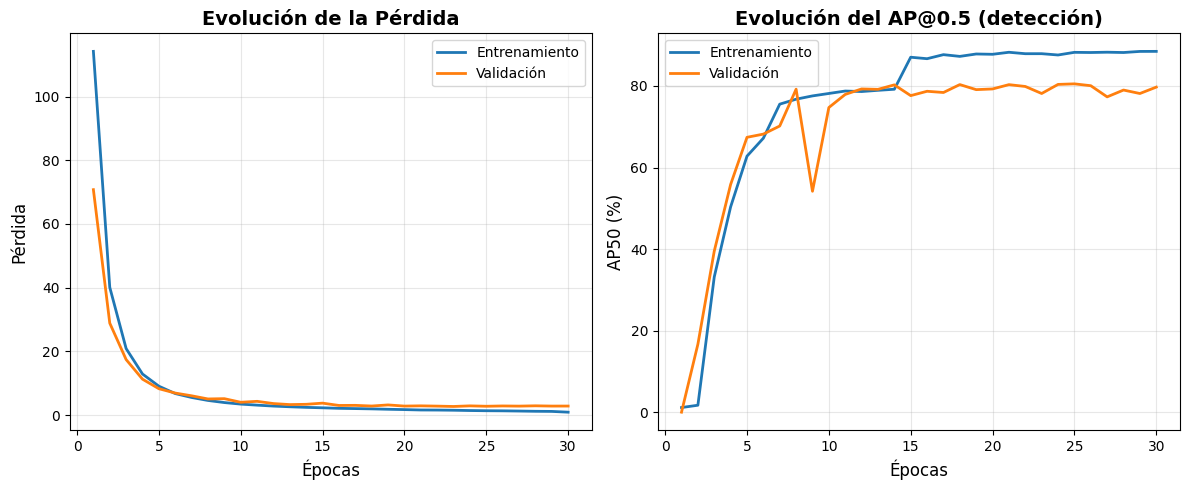

In [14]:
# Número real de épocas entrenadas (por si paraste antes con early stopping)
epochs = np.arange(1, len(history["train_loss"]) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# ==========================
# 1) Pérdida (Loss)
# ==========================
axs[0].plot(epochs, history["train_loss"], label='Entrenamiento', linewidth=2)
axs[0].plot(epochs, history["val_loss"],   label='Validación',   linewidth=2)
axs[0].set_title('Evolución de la Pérdida', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Épocas', fontsize=12)
axs[0].set_ylabel('Pérdida', fontsize=12)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# ==========================
# 2) AP50 
# ==========================
axs[1].plot(epochs, np.array(history["train_ap50"]) * 100,
            label='Entrenamiento', linewidth=2)
axs[1].plot(epochs, np.array(history["val_ap50"]) * 100,
            label='Validación', linewidth=2)
axs[1].set_title('Evolución del AP@0.5 (detección)', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Épocas', fontsize=12)
axs[1].set_ylabel('AP50 (%)', fontsize=12)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Carga del mejor modelo entrenado para evaluación

Esta celda configura el dispositivo, define la clase y los mismos anchors usados en el entrenamiento, instancia ImprovedPlateDetector, carga los pesos guardados en best_plate_detector.pth, pone el modelo en modo evaluación y deja listo el detector de placas para inferencia y métricas.

In [15]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Solo una clase: placa
num_classes = 1
image_size = (416, 416)

# ⚠️ IMPORTANTE: usar los mismos anchors que en el entrenamiento
anchors_kmeans = np.array([
    [47.977596, 30.171726],
    [95.66016 , 75.83388 ],
    [357.70685, 279.4956 ]
], dtype=np.float32)

# Instanciar el modelo EXACTAMENTE igual que durante el entrenamiento
best_model = ImprovedPlateDetector(
    num_classes=num_classes,
    image_size=image_size,
    num_anchors=anchors_kmeans.shape[0],
    anchors=anchors_kmeans.tolist()
).to(device)

# Cargar pesos del mejor modelo guardado
state_dict = torch.load('best_plate_detector.pth', map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()  # Muy importante para inferencia / métricas

# Nombres de clase (aunque solo sea una)
class_names = ['LicensePlate']  # o ['Placa']

print("✅ Mejor modelo cargado correctamente y listo para evaluación.")


✅ Mejor modelo cargado correctamente y listo para evaluación.


## Cálculo de métricas de detección y visualización de resultados

Esta celda define funciones para evaluar el detector: calculate_detection_metrics calcula loss promedio, AP@0.5, precisión, recall y F1 por clase; plot_normalized_confusion_matrix dibuja la matriz de confusión normalizada; y per_class_metrics imprime un resumen detallado de TP, FP, FN y métricas por clase.

In [16]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ============================================================================
# MÉTRICAS PARA DETECCIÓN DE OBJETOS
# ============================================================================

def calculate_detection_metrics(model,
                                dataloader,
                                device,
                                num_classes,
                                class_names=None,
                                anchors=None,
                                image_size=(416, 416),
                                conf_threshold=0.25,
                                iou_threshold=0.5,
                                lambda_coord=5.0,
                                lambda_obj=2.0,
                                lambda_noobj=0.5,
                                nms_iou_threshold=0.5):
    """
    Calcula métricas para el modelo ImprovedPlateDetector.

    Retorna:
      metrics_dict con:
        - loss promedio
        - ap50 global (detección)
        - precision/recall/F1 por clase
        - true_classes / pred_classes para matriz de confusión
        - tp/fp/fn por clase
    """
    model.eval()
    if class_names is None:
        class_names = [f"Class_{i}" for i in range(num_classes)]

    total_loss = 0.0
    all_dets = []
    all_gts = []

    # Contadores por clase
    class_tp = np.zeros(num_classes)
    class_fp = np.zeros(num_classes)
    class_fn = np.zeros(num_classes)

    # Para matriz de confusión (solo TPs)
    all_true_classes = []
    all_pred_classes = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Calculating metrics"):
            images = images.to(device)
            targets = [t.to(device) for t in targets]

            # Forward
            predictions = model(images)  # [B,A,H,W,5+C]

            # Loss YOLO
            loss, loss_dict = yolo_plate_loss(
                predictions=predictions,
                targets=targets,
                anchors=anchors,
                num_classes=num_classes,
                image_size=image_size,
                lambda_coord=lambda_coord,
                lambda_obj=lambda_obj,
                lambda_noobj=lambda_noobj
            )
            total_loss += loss.item()

            # Guardar GTs (normalizados) en CPU
            all_gts.extend([t.detach().cpu() for t in targets])

            # Obtener detecciones decodificadas y filtradas por confianza + NMS
            batch_dets = gather_detections_from_batch(
                model=model,
                predictions=predictions,
                image_size=image_size,
                conf_threshold=conf_threshold,
                nms_iou_threshold=nms_iou_threshold
            )
            all_dets.extend([d.detach().cpu() for d in batch_dets])

            # ---------------------------------------------------------
            # Contar TP, FP, FN por clase
            # ---------------------------------------------------------
            B = len(targets)
            for b in range(B):
                dets = batch_dets[b].detach().cpu()    # [N_det, 6] (cx,cy,w,h,score,class_id)
                gts  = targets[b].detach().cpu()       # [N_gt, 5]  (class_id,cx,cy,w,h)

                if gts.numel() == 0 and dets.numel() == 0:
                    continue

                gt_boxes = gts[:, 1:5] if gts.numel() > 0 else torch.zeros((0,4))
                gt_classes = gts[:, 0].long() if gts.numel() > 0 else torch.zeros(0, dtype=torch.long)

                det_boxes = dets[:, :4] if dets.numel() > 0 else torch.zeros((0,4))
                det_scores = dets[:, 4] if dets.numel() > 0 else torch.zeros(0)
                det_classes = dets[:, 5].long() if dets.numel() > 0 else torch.zeros(0, dtype=torch.long)

                # Para matching IoU, pasamos a xyxy (coordenadas normalizadas [0,1])
                if det_boxes.numel() > 0:
                    det_xyxy = xywh_to_xyxy(det_boxes)
                else:
                    det_xyxy = torch.zeros((0,4))

                if gt_boxes.numel() > 0:
                    gt_xyxy = xywh_to_xyxy(gt_boxes)
                else:
                    gt_xyxy = torch.zeros((0,4))

                # Matriz iou [N_det, N_gt]
                if det_xyxy.numel() > 0 and gt_xyxy.numel() > 0:
                    ious = box_iou(det_xyxy, gt_xyxy)  # [N_det,N_gt]
                else:
                    ious = torch.zeros((det_xyxy.shape[0], gt_xyxy.shape[0]))

                # Control de GT ya emparejados
                matched_gt = torch.zeros(gt_boxes.shape[0], dtype=torch.bool)

                for d_idx in range(det_boxes.shape[0]):
                    d_class = int(det_classes[d_idx].item())

                    if gt_boxes.shape[0] == 0:
                        # no hay GT -> todo FP
                        class_fp[d_class] += 1
                        continue

                    # IoUs de esta detección con todos los GT
                    ious_d = ious[d_idx]  # [N_gt]
                    max_iou, max_gt_idx = (ious_d.max(0) if ious_d.numel() > 0
                                           else (torch.tensor(0.0), torch.tensor(0)))

                    gt_class = int(gt_classes[max_gt_idx].item()) if gt_boxes.shape[0] > 0 else -1

                    if max_iou >= iou_threshold and not matched_gt[max_gt_idx] and d_class == gt_class:
                        # Verdadero positivo
                        class_tp[d_class] += 1
                        matched_gt[max_gt_idx] = True

                        all_true_classes.append(gt_class)
                        all_pred_classes.append(d_class)
                    else:
                        # Falso positivo (detección que no empareja GT correcto)
                        class_fp[d_class] += 1

                # Falsos negativos: GT que quedaron sin detectar
                for g_idx in range(gt_boxes.shape[0]):
                    if not matched_gt[g_idx]:
                        g_class = int(gt_classes[g_idx].item())
                        class_fn[g_class] += 1

    # ========================== MÉTRICAS GLOBALES ==========================
    avg_loss = total_loss / len(dataloader)

    # AP50 global (para 1 clase es AP de placa)
    ap50 = compute_ap50_single_class(all_dets, all_gts, iou_threshold=iou_threshold)

    # Precision/Recall/F1 por clase
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for c in range(num_classes):
        tp = class_tp[c]
        fp = class_fp[c]
        fn = class_fn[c]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)

    # Reporte bonito en consola
    print("\n" + "="*60)
    print("DETECTION METRICS")
    print("="*60)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"AP@0.5: {ap50*100:.2f}%")
    print("\nPER-CLASS METRICS")
    print("-"*60)
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-"*60)

    for i, name in enumerate(class_names):
        print(f"{name:<20} {precision_per_class[i]*100:>10.2f}% {recall_per_class[i]*100:>10.2f}% {f1_per_class[i]*100:>10.2f}%")

    print("-"*60)
    print(f"{'Mean':<20} {np.mean(precision_per_class)*100:>10.2f}% {np.mean(recall_per_class)*100:>10.2f}% {np.mean(f1_per_class)*100:>10.2f}%")
    print("="*60 + "\n")

    # Diccionario de métricas
    metrics_dict = {
        "loss": avg_loss,
        "ap50": ap50,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "f1_per_class": f1_per_class,
        "true_classes": all_true_classes,
        "pred_classes": all_pred_classes,
        "class_tp": class_tp,
        "class_fp": class_fp,
        "class_fn": class_fn
    }

    # Classification report solo si hay TPs
    if len(all_true_classes) > 0 and len(all_pred_classes) > 0:
        unique_classes = sorted(list(set(all_true_classes + all_pred_classes)))
        labels_present = [class_names[i] for i in unique_classes]

        print("Classification Report (solo detecciones emparejadas):")
        print(classification_report(
            all_true_classes,
            all_pred_classes,
            labels=unique_classes,
            target_names=labels_present,
            zero_division=0
        ))

    return metrics_dict


def plot_normalized_confusion_matrix(metrics_dict, class_names=None, figsize=(6, 5), save_path=None):
    """
    Plotea matriz de confusión normalizada para detección (solo clases de TPs).
    """
    y_true = metrics_dict['true_classes']
    y_pred = metrics_dict['pred_classes']

    if len(y_true) == 0 or len(y_pred) == 0:
        print("No hay suficientes datos para generar la matriz de confusión")
        return None

    num_classes = len(metrics_dict['precision_per_class'])

    if class_names is None:
        class_names = [f"Class_{i}" for i in range(num_classes)]

    unique_classes = sorted(list(set(y_true + y_pred)))
    labels_present = [class_names[i] for i in unique_classes]

    cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized,
                annot=True,
                fmt=".2f",
                cmap="Blues",
                xticklabels=labels_present,
                yticklabels=labels_present,
                cbar_kws={'label': 'Proporción'})

    plt.title("Matriz de Confusión Normalizada (Detección)", fontsize=14, fontweight='bold')
    plt.ylabel("Clase Real", fontsize=12)
    plt.xlabel("Clase Predicha", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()
    return cm_normalized


def per_class_metrics(metrics_dict, class_names=None):
    """
    Muestra métricas detalladas por clase a partir de metrics_dict.
    """
    precision_per_class = metrics_dict['precision_per_class']
    recall_per_class = metrics_dict['recall_per_class']
    f1_per_class = metrics_dict['f1_per_class']

    if class_names is None:
        class_names = [f"Class_{i}" for i in range(len(precision_per_class))]

    print("\n" + "="*70)
    print("DETAILED PER-CLASS METRICS")
    print("="*70)
    print(f"{'Class':<20} {'TP':<8} {'FP':<8} {'FN':<8} "
          f"{'Precision':<12} {'Recall':<12} {'F1':<12}")
    print("-"*70)

    for i, name in enumerate(class_names):
        tp = metrics_dict['class_tp'][i]
        fp = metrics_dict['class_fp'][i]
        fn = metrics_dict['class_fn'][i]
        precision = precision_per_class[i]
        recall = recall_per_class[i]
        f1 = f1_per_class[i]

        print(f"{name:<20} {int(tp):<8} {int(fp):<8} {int(fn):<8} "
              f"{precision*100:>10.2f}% {recall*100:>10.2f}% {f1*100:>10.2f}%")

    print("-"*70)
    print(f"{'Mean':<20} {'':<8} {'':<8} {'':<8} "
          f"{np.mean(precision_per_class)*100:>10.2f}% "
          f"{np.mean(recall_per_class)*100:>10.2f}% "
          f"{np.mean(f1_per_class)*100:>10.2f}%")
    print("="*70 + "\n")

    return {
        "precision": precision_per_class,
        "recall": recall_per_class,
        "f1": f1_per_class
    }


## Cálculo de métricas finales en el conjunto de prueba

Esta celda evalúa el best_model sobre el conjunto test_data usando calculate_detection_metrics, obteniendo loss, AP@0.5 y métricas por clase, y confirma que el cálculo de métricas se realizó correctamente.

In [17]:
# ============================================================================
# CALCULAR MÉTRICAS DEL MODELO EN VALIDACIÓN O TEST
# ============================================================================

metrics = calculate_detection_metrics(
    model=best_model,
    dataloader=test_data,    # -> puedes cambiar a test_data si quieres
    device=device,
    num_classes=num_classes,
    class_names=class_names,
    anchors=best_model.anchors,   # MUY importante
    image_size=image_size,
    conf_threshold=0.25,
    iou_threshold=0.5,
    lambda_coord=5.0,
    lambda_noobj=0.5
)

print("\nMétricas calculadas correctamente.")

Calculating metrics: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]



DETECTION METRICS
Average Loss: 2.5890
AP@0.5: 81.09%

PER-CLASS METRICS
------------------------------------------------------------
Class                Precision    Recall       F1-Score    
------------------------------------------------------------
LicensePlate              91.90%      89.95%      90.92%
------------------------------------------------------------
Mean                      91.90%      89.95%      90.92%

Classification Report (solo detecciones emparejadas):
              precision    recall  f1-score   support

LicensePlate       1.00      1.00      1.00       976

    accuracy                           1.00       976
   macro avg       1.00      1.00      1.00       976
weighted avg       1.00      1.00      1.00       976


Métricas calculadas correctamente.


## Mostrar métricas detalladas por clase

Esta celda llama a per_class_metrics con las métricas calculadas y los nombres de clase, imprime en consola los valores de TP, FP, FN, precisión, recall y F1 por clase, y guarda el resumen en detailed_metrics.

In [18]:
# ============================================================================
# MOSTRAR MÉTRICAS DETALLADAS POR CLASE
# ============================================================================

detailed_metrics = per_class_metrics(metrics, class_names=class_names)



DETAILED PER-CLASS METRICS
Class                TP       FP       FN       Precision    Recall       F1          
----------------------------------------------------------------------
LicensePlate         976      86       109           91.90%      89.95%      90.92%
----------------------------------------------------------------------
Mean                                                 91.90%      89.95%      90.92%



## Carga y reconstrucción del mejor modelo desde best_plate_detector.pth

Esta celda carga el state_dict guardado en best_plate_detector.pth, reconstruye el modelo ImprovedPlateDetector con los mismos parámetros y anchors del entrenamiento, restaura los pesos, lo pone en modo evaluación y lo deja listo para hacer inferencia o calcular métricas.

In [19]:
# ============================================================================
# CARGAR EL MEJOR MODELO DESDE best_plate_detector.pth (SOLO STATE_DICT)
# ============================================================================

import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mismos parámetros que usaste al entrenar
num_classes = 1
image_size = (416, 416)

# Anchors de k-means que usaste en el entrenamiento
anchors_kmeans = np.array([
    [47.977596, 30.171726],
    [95.66016 , 75.83388 ],
    [357.70685, 279.4956 ]
], dtype=np.float32)

# Cargar archivo: aquí SOLO hay state_dict, no hay 'anchors', 'num_classes', etc.
state_dict = torch.load("best_plate_detector.pth", map_location=device)
print("📂 State dict cargado correctamente desde best_plate_detector.pth")

# Reconstruir el modelo EXACTAMENTE igual que en el entrenamiento
loaded_model = ImprovedPlateDetector(
    num_classes=num_classes,
    image_size=image_size,
    num_anchors=anchors_kmeans.shape[0],
    anchors=anchors_kmeans.tolist()
).to(device)

# Cargar pesos
loaded_model.load_state_dict(state_dict)
loaded_model.eval()

print("✅ Modelo restaurado y listo para inferencia / métricas")
print("Anchors usados:", anchors_kmeans)
print("Image size usado:", image_size)


📂 State dict cargado correctamente desde best_plate_detector.pth
✅ Modelo restaurado y listo para inferencia / métricas
Anchors usados: [[ 47.977596  30.171726]
 [ 95.66016   75.83388 ]
 [357.70685  279.4956  ]]
Image size usado: (416, 416)


## Convertir modelo a TorchScript

Esta celda reconstruye el ImprovedPlateDetector con los mismos parámetros y pesos entrenados, crea una entrada dummy, genera una versión trazada en TorchScript con torch.jit.trace y la guarda en el archivo plate_detector_ts.pt lista para despliegue.

In [20]:
# ============================================================================
# CONVERTIR ImprovedPlateDetector A TORCHSCRIPT (SIN CUANTIZACIÓN) - GPU
# ============================================================================

import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Mismos parámetros que usaste al entrenar
num_classes = 1
image_size = (416, 416)

anchors_kmeans = np.array([
    [47.977596, 30.171726],
    [95.66016 , 75.83388 ],
    [357.70685, 279.4956 ]
], dtype=np.float32)

# 1. Cargar el state_dict
state_dict = torch.load("best_plate_detector.pth", map_location=device)
print("📂 State dict cargado correctamente desde best_plate_detector.pth")

# 2. Reconstruir el modelo EXACTAMENTE igual que en entrenamiento
loaded_model = ImprovedPlateDetector(
    num_classes=num_classes,
    image_size=image_size,
    num_anchors=anchors_kmeans.shape[0],
    anchors=anchors_kmeans.tolist()
).to(device)

loaded_model.load_state_dict(state_dict)
loaded_model.eval()

print("✅ Modelo restaurado y listo para TorchScript")
print("Anchors usados:", anchors_kmeans)
print("Image size usado:", image_size)

# 3. Dummy input en EL MISMO device que el modelo
dummy_input = torch.randn(1, 3, image_size[0], image_size[1], device=device)

# 4. Trazar el modelo a TorchScript
with torch.no_grad():
    traced_ts_model = torch.jit.trace(loaded_model, dummy_input)

# 5. Guardar el modelo en formato TorchScript
traced_ts_model.save("plate_detector_ts.pt")

print("🚀 Modelo de detección de placas exportado a TorchScript (plate_detector_ts.pt)")


Usando device: cuda
📂 State dict cargado correctamente desde best_plate_detector.pth
✅ Modelo restaurado y listo para TorchScript
Anchors usados: [[ 47.977596  30.171726]
 [ 95.66016   75.83388 ]
 [357.70685  279.4956  ]]
Image size usado: (416, 416)
🚀 Modelo de detección de placas exportado a TorchScript (plate_detector_ts.pt)


## Exportar el detector de placas a TorchScript para ejecución solo en CPU

Esta celda carga el mejor modelo en CPU, lo reconstruye con los mismos parámetros y anchors, crea una entrada dummy, lo convierte a TorchScript usando torch.jit.trace y guarda la versión para CPU en el archivo plate_detector_ts_cpu.pt.

In [21]:
# ============================================================================
# CONVERTIR ImprovedPlateDetector A TORCHSCRIPT (SIN CUANTIZACIÓN) - SOLO CPU
# ============================================================================

import torch
import numpy as np

device = torch.device("cpu")
print("Usando device:", device)

num_classes = 1
image_size = (416, 416)

anchors_kmeans = np.array([
    [47.977596, 30.171726],
    [95.66016 , 75.83388 ],
    [357.70685, 279.4956 ]
], dtype=np.float32)

# 1. Cargar el state_dict SIEMPRE EN CPU
state_dict = torch.load("best_plate_detector.pth", map_location=device)
print("📂 State dict cargado correctamente desde best_plate_detector.pth")

# 2. Reconstruir el modelo en CPU
loaded_model = ImprovedPlateDetector(
    num_classes=num_classes,
    image_size=image_size,
    num_anchors=anchors_kmeans.shape[0],
    anchors=anchors_kmeans.tolist()
).to(device)

loaded_model.load_state_dict(state_dict)
loaded_model.eval()

print("✅ Modelo restaurado en CPU y listo para TorchScript")

# 3. Dummy input en CPU
dummy_input = torch.randn(1, 3, image_size[0], image_size[1], device=device)

# 4. Trazar el modelo
with torch.no_grad():
    traced_ts_model = torch.jit.trace(loaded_model, dummy_input)

# 5. Guardar el modelo TorchScript
traced_ts_model.save("plate_detector_ts_cpu.pt")

print("🚀 Modelo exportado a TorchScript (plate_detector_ts_cpu.pt) en CPU")


Usando device: cpu
📂 State dict cargado correctamente desde best_plate_detector.pth
✅ Modelo restaurado en CPU y listo para TorchScript
🚀 Modelo exportado a TorchScript (plate_detector_ts_cpu.pt) en CPU


## Comparación de tamaño y velocidad entre modelos PyTorch y TorchScript

Esta celda carga el modelo TorchScript, compara en MB el tamaño del archivo .pth vs .pt y ejecuta un benchmark (benchmark_model) para medir el tiempo promedio de inferencia de ambos modelos, mostrando si TorchScript ofrece alguna mejora de velocidad.

In [22]:
import time

# ============================================================================
# 1. CARGAR MODELO TorchScript (plate_detector_ts.pt), NO SE CARGA MODELO 
    #PYTORCH YA QUE SE CARGO PREVIAMENTE
# ============================================================================

ts_model = torch.jit.load("plate_detector_ts_cpu.pt", map_location=device)
ts_model.eval()
ts_model.to(device)

# ============================================================================
# 2. COMPARAR TAMAÑO EN DISCO
# ============================================================================

pth_size_mb = os.path.getsize("best_plate_detector.pth") / (1024 ** 2)
pt_size_mb  = os.path.getsize("plate_detector_ts_cpu.pt") / (1024 ** 2)

print(f"💾 Tamaño best_plate_detector.pth : {pth_size_mb:.2f} MB")
print(f"💾 Tamaño plate_detector_ts_cpu.pt    : {pt_size_mb:.2f} MB\n")

# ============================================================================
# 3. MEDIR TIEMPO DE INFERENCIA
# ============================================================================

def benchmark_model(model, n_warmup=10, n_runs=50, name="modelo"):
    """
    Mide el tiempo promedio de inferencia (forward) en ms.
    """
    model.to(device)
    model.eval()

    # Input fijo para el benchmark
    x = torch.randn(1, 3, image_size[0], image_size[1], device=device)

    # Warmup (importante en GPU)
    with torch.no_grad():
        for _ in range(n_warmup):
            _ = model(x)

    # Benchmark real
    torch.cuda.empty_cache() if device.type == "cuda" else None

    times = []
    with torch.no_grad():
        for _ in range(n_runs):
            start = time.perf_counter()
            _ = model(x)
            end = time.perf_counter()
            times.append((end - start) * 1000.0)  # ms

    mean_ms = np.mean(times)
    std_ms = np.std(times)
    print(f"⏱ {name}: {mean_ms:.3f} ± {std_ms:.3f} ms por inferencia "
          f"(n={n_runs})")
    return mean_ms, std_ms

print("Benchmarking modelos...\n")
t_eager_mean, t_eager_std = benchmark_model(loaded_model, name="PyTorch (eager)")
t_ts_mean, t_ts_std       = benchmark_model(ts_model,    name="TorchScript (.pt)")

print("\nResumen tiempos:")
print(f"→ PyTorch (loaded):  {t_eager_mean:.3f} ms")
print(f"→ TorchScript (.pt): {t_ts_mean:.3f} ms")
print(f"Speedup aproximado: {t_eager_mean / t_ts_mean:.2f}x (si >1, TS es más rápido)\n")

💾 Tamaño best_plate_detector.pth : 38.08 MB
💾 Tamaño plate_detector_ts_cpu.pt    : 38.27 MB

Benchmarking modelos...

⏱ PyTorch (eager): 299.799 ± 4.276 ms por inferencia (n=50)
⏱ TorchScript (.pt): 303.697 ± 8.123 ms por inferencia (n=50)

Resumen tiempos:
→ PyTorch (loaded):  299.799 ms
→ TorchScript (.pt): 303.697 ms
Speedup aproximado: 0.99x (si >1, TS es más rápido)

